In [1]:
import requests

load_data = False

if load_data:
    xB = \
    requests.get('https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/framsoknarflokkur.json').json()[
        'pageProps']
    xC = requests.get('https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/vidreisn.json').json()[
        'pageProps']
    xD = \
        requests.get(
            'https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/sjalfstaedisflokkur.json').json()[
            'pageProps']
    xF = \
    requests.get('https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/flokkur-folksins.json').json()[
        'pageProps']
    xJ = requests.get(
        'https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/sosialistaflokkur-islands.json').json()[
        'pageProps']
    xL = \
    requests.get('https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/lydraedisflokkur.json').json()[
        'pageProps']
    xM = requests.get('https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/midflokkur.json').json()[
        'pageProps']
    xP = requests.get('https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/piratar.json').json()[
        'pageProps']
    xS = requests.get('https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/samfylkingin.json').json()[
        'pageProps']
    xV = requests.get(
        'https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/vinstrihreyfingin-graent-frambod.json').json()[
        'pageProps']
    xY = requests.get('https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/flokkar/abyrg-framtid.json').json()[
        'pageProps']
    data: dict[str, dict] = {
        'xB': xB,
        'xC': xC,
        'xD': xD,
        'xF': xF,
        'xJ': xJ,
        'xL': xL,
        'xM': xM,
        'xP': xP,
        'xS': xS,
        'xV': xV,
        'xY': xY,
    }
else:
    data: dict[str, dict] = {
        'xB': {},
        'xC': {},
        'xD': {},
        'xF': {},
        'xJ': {},
        'xL': {},
        'xM': {},
        'xP': {},
        'xS': {},
        'xV': {},
        'xY': {},
    }



In [2]:
from typing import TypedDict, Literal, List, Dict


class Question(TypedDict):
    id: str
    type: Literal['PROPOSITION', 'PRIORITY', 'RANGE']
    slug: str
    title: str
    __typename: str


class Constituency(TypedDict):
    id: str
    name: str
    candidates: list[dict]


class PartyCandidate(TypedDict):
    fullName: str
    partyListPosition: int
    slug: str
    constituency: dict


class Answer(TypedDict):
    important: bool
    reasoning: str
    questionId: str
    questionType: Literal['PROPOSITION', 'PRIORITY', 'RANGE']
    stringValue: str
    value: str
    question: Question


class CandidateAnswer(TypedDict):
    id: str
    motivateVote: str
    fullName: str
    party: dict[str, str]
    partyCode: str
    partyListPosition: int
    backgroundQuestion: list[dict]
    constituency: dict
    answers: list[Answer]


class Party(TypedDict):
    slug: str
    name: str
    abbreviation: str
    backgroundQuestion: list[dict]
    answers: list[Answer]


class Data(TypedDict):
    party: dict
    partyCandidates: list[PartyCandidate]
    constituencies: list[Constituency]
    app: dict


In [3]:

# Define the base URL
BASE_URL = "https://kosningaprof.ruv.is/_next/data/VZIihpoHQ03jAZ6A6Z_bX/frambjodandi/{slug}.json"


def fetch_candidate_answers(candidate_slug: str) -> CandidateAnswer:
    """Fetch answers for a candidate by their slug."""
    url = BASE_URL.format(slug=candidate_slug)
    response = requests.get(url)

    if response.status_code == 200:
        json_data = response.json()
        # Navigate to the `answers` section of the data
        candidate_data = json_data.get('pageProps', {}).get('candidate', {})
        return candidate_data
    else:
        print(f"Failed to fetch data for {candidate_slug}: {response.status_code}")
        return []


def collect_all_answers(party_data: Dict[str, Data]) -> Dict[str, dict[str, List[Answer]]]:
    """Collect answers for all candidates in the provided data."""
    all_answers = {}

    for key, constituency_data in party_data.items():
        all_answers[key] = {}
        for candidate in constituency_data.get('partyCandidates', []):
            candidate_slug = candidate['slug']
            all_answers[key][candidate_slug] = fetch_candidate_answers(candidate_slug)

    return all_answers

# fetch_candidate_answers('dilja-mist-einarsdottir-6ren-d-2')

In [4]:
import json

# all_candidate_answers = collect_all_answers(data)
# for partyKey, party in all_candidate_answers.items():
#     print(f"Party {partyKey} has {len(party.keys())} candidates.")

# Save all_candidate_answers to a file
# with open('./candidate_answers.json', 'w', encoding='utf-8') as f:
#     json.dump(all_candidate_answers, f, ensure_ascii=False, indent=4)

with open('./candidate_answers.json', 'r', encoding='utf-8') as f:
    all_candidate_answers: Dict[str, dict[str, List[Answer]]] = json.load(f)

In [101]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

candidates = []
labels = []
sizes = []
partyListPositions = []
candidate_names = []

for constituency in all_candidate_answers.values():
    for candidate_slug, candidate_data in constituency.items():
        answers = candidate_data["answers"]
        partyListPosition = candidate_data["partyListPosition"]
        candidate_name = candidate_data["fullName"]
        sizes.append(100 / (partyListPosition + 1))
        feature_vector = [answer["stringValue"] for answer in answers]
        
        candidates.append(feature_vector)
        labels.append(candidate_data["partyCode"])
        
        partyListPositions.append(partyListPosition)
        candidate_names.append(candidate_name)

# Convert answers into a DataFrame
df = pd.DataFrame(candidates).fillna("")
# Encode string answers as integers
encoder = LabelEncoder()
df_encoded = df.apply(encoder.fit_transform)
tsne = TSNE(init="random", n_components=2, random_state=42, metric="precomputed", early_exaggeration=7)
distance_matrix = cosine_distances(df_encoded)
reduced_data = tsne.fit_transform(distance_matrix)


Sigurður Ingi Jóhannsson 7.927302 5.8813415
Inga Sæland -6.8572783 15.771177


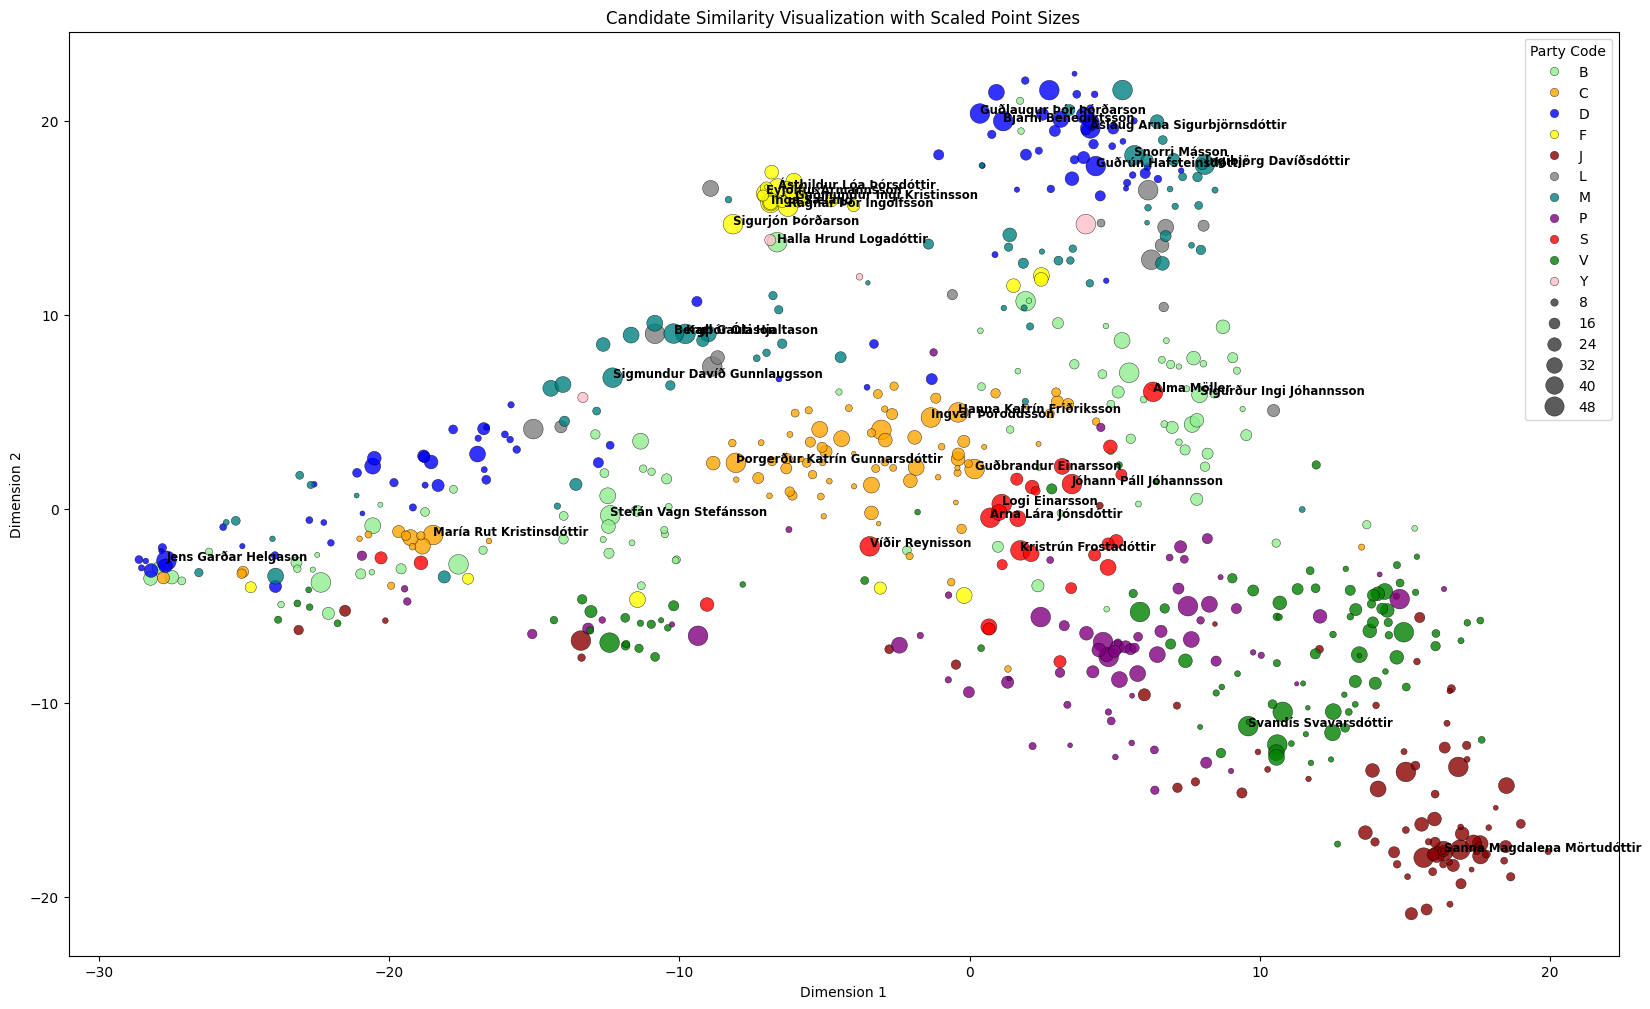

In [102]:
# Define a size scale: inverse of partyListPosition for larger size with lower position
# scale_factor = 3  # Adjust this factor to exaggerate more or less
# exaggerated_data = reduced_data * scale_factor
# Plot with scaled point sizes
plt.figure(figsize=(20, 12))
party_colors = {
    "B": "lightgreen",
    "C": "orange",
    "D": "blue",
    "F": "yellow",
    "J": "darkred",
    "L": "grey",
    "M": "teal",
    "P": "purple",
    "S": "red",
    "V": "green",
    "Y": "pink",
}
sns.scatterplot(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    hue=labels,
    size=sizes,
    sizes=(10, 200),  # Minimum and maximum point sizes
    alpha=0.8,
    edgecolor="k",
    palette=party_colors
)  

names_voted_in = [
    "Ingibjörg Isaksen", "Þórarinn Ingi Pétursson", "Stefán Vagn Stefánsson", "Halla Hrund Logadóttir", "Sigurður Ingi Jóhannsson",
    "Ingvar Þóroddsson", "María Rut Kristinsdóttir", "Hanna Katrín Friðriksson", "Pawel Bartoszek", "Grímur Grímsson", "Þorbjörg Sigríður Gunnlaugsdóttir", "Jón Gnarr", "Guðbrandur Einarsson", "Þorgerður Katrín Gunnarsdóttir", "Sigmar Guðmundsson", "Eiríkur Björn Björgvinsson",
    "Jens Garðar Helgason", "Njáll Trausti Friðbertsson", "Ólafur Adolfsson", "Guðlaugur Þór Þórðarson", "Diljá Mist Einarsdóttir", "Áslaug Arna Sigurbjörnsdóttir", "Hildur Sverrisdóttir", "Jón Pétur Zimsen", "Guðrún Hafsteinsdóttir", "Vilhjálmur Árnason", "Bjarni Benediktsson", "Þórdís Kolbrún Reykfjörð Gylfadóttir", "Bryndís Haraldsdóttir", "Rósa Guðbjartsdóttir",
    "Sigurjón Þórðarson", "Eyjólfur Ármannsson", "Lilja Rafney Magnúsdóttir", "Ragnar Þór Ingólfsson", "Inga Sæland", "Kolbrún Áslaugar Baldursdóttir", "Ásthildur Lóa Þórsdóttir", "Sigurður Helgi Pálmason", "Guðmundur Ingi Kristinsson", "Jónína Björk Óskarsdóttir",
    "Sigmundur Davíð Gunnlaugsson", "Þorgrímur Sigmundsson", "Ingibjörg Davíðsdóttir", "Sigríður Á. Anderson", "Snorri Másson", "Karl Gauti Hjaltason", "Bergþór Ólason", "Nanna Margrét Gunnlaugsdóttir",
    "Logi Einarsson", "Eydís Ásbjörnsdóttir", "Arna Lára Jónsdóttir", "Kristrún Frostadóttir", "Dagur B. Eggertsson", "Þórður Snær Júlíusson", "Dagbjört Hákonardóttir", "Jóhann Páll Jóhannsson", "Ragna Sigurðardóttir", "Kristján Þórður Snæbjarnarson", "Víðir Reynisson", "Ása Berglind Hjálmarsdóttir", "Alma Möller", "Guðmundur Ari Sigurjónsson", "Þórunn Sveinbjarnardóttir"
]
names_hand_picked = ["Sanna Magdalena Mörtudóttir", "Svandís Svavarsdóttir", "Sigurður Ingi Jóhannsson"]

for (x, y), name, pos in zip(reduced_data, candidate_names, partyListPositions):
    if name in names_voted_in and pos == 1 or name in names_hand_picked: 
        if name == "Inga Sæland":
            print(name, x, y)
        if name == "Sigurður Ingi Jóhannsson":
            print(name, x, y)
        plt.text(x, y, name, size='small', ha='left', color='black', weight='semibold')

plt.title("Candidate Similarity Visualization with Scaled Point Sizes")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Party Code", loc="best")
plt.show()
